# 📘 Day 2 (04/11) — Supervised Fine-Tuning, LoRA e QLoRA

**Obiettivo pratico (4 ore di codice)**: Apprendere il Supervised Fine-Tuning (SFT) e metodi efficienti (LoRA, QLoRA) su dataset IMDB per sentiment analysis con DistilBERT e GPT-2.

---

## 🗺️ Roadmap della lezione (240 minuti di codice)

| **Sezione** | **Contenuto** | **Tempo stimato** |
|-------------|---------------|-------------------|
| 1 | Setup e teoria SFT | 20' |
| 2 | Preparazione dataset IMDB | 30' |
| 3 | SFT su DistilBERT (classification) | 60' |
| 4 | LoRA su GPT-2 | 50' |
| 5 | QLoRA su GPT-2 | 50' |
| 6 | Confronto base vs fine-tuned | 30' |
| **TOTALE** | | **240'** |

---

## 📚 Leggi dopo (teoria fuori orario)

### Supervised Fine-Tuning (SFT)
- **Definizione**: adattare un modello pre-trained a un task specifico usando dati labeled
- **Differenza da pre-training**: pre-training usa dati non supervisionati (next token prediction), SFT usa dati labeled (es. sentiment, QA)
- **Vantaggi**: costi ridotti, specializzazione, performance migliori su task specifici
- **Svantaggi**: rischio overfitting su dataset piccoli, dipendenza da qualità labels

### LoRA (Low-Rank Adaptation)
- **Paper**: Hu et al., 2021 - "LoRA: Low-Rank Adaptation of Large Language Models"
- **Idea**: invece di aggiornare tutti i pesi W, aggiungi matrici low-rank A e B
- **Formula**: `W' = W + BA` dove B ∈ R^(d×r), A ∈ R^(r×k), r << d
- **Vantaggi**: riduce parametri trainable del 90-99%, memoria ridotta, training più veloce
- **Parametri chiave**:
  - `r` (rank): dimensione bottleneck (tipicamente 4-64)
  - `alpha`: scaling factor (tipicamente 16-32)
  - `target_modules`: quali layer modificare (query, value, etc.)

### QLoRA (Quantized LoRA)
- **Paper**: Dettmers et al., 2023 - "QLoRA: Efficient Finetuning of Quantized LLMs"
- **Idea**: combina quantizzazione (int4/int8) + LoRA
- **Vantaggi**: riduce memoria del 75% rispetto a LoRA, permette fine-tuning di modelli grandi su GPU consumer
- **Libreria**: `bitsandbytes` per quantizzazione

### Librerie di supporto
- **PEFT** (Parameter-Efficient Fine-Tuning): libreria Hugging Face per LoRA, QLoRA, etc.
- **Axolotl**: framework per fine-tuning con config YAML
- **DeepSpeed**: ottimizzazioni per training distribuito (ZeRO optimizer)
- **Hugging Face Trainer**: API high-level per training

---

## 1️⃣ Setup e teoria SFT (20 minuti)

In [1]:
# Installazione librerie
%pip install torch transformers datasets peft bitsandbytes accelerate scikit-learn matplotlib pandas numpy -q

Note: you may need to restart the kernel to use updated packages.


Dopo l'installazione, se appare il messaggio che chiede di riavviare il kernel, dalla toolbar in alto selezionare **"Kernel"** e in seguito **"Restart Kernel and Clear Outputs of All Cells..."** 

**Attendere circa 30 secondi e in seguito NON eseguire nuovamente il blocco "Installazione librerie" ma procedere con il blocco successivo, "Import librerie"**

In [2]:
# Import librerie
import torch
import transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    Trainer, 
    TrainingArguments,
    set_seed
)
from transformers.utils import logging as hf_logging
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Seed
SEED = 42
set_seed(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✅ Trasformers version: {transformers.__version__}")
print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Device: {device}")
print(f"✅ Seed: {SEED}")

✅ Trasformers version: 4.57.1
✅ PyTorch: 2.8.0+cpu
✅ Device: cpu
✅ Seed: 42


In [3]:
# Creazione directory
os.makedirs('./data', exist_ok=True)
os.makedirs('./results_day2', exist_ok=True)
os.makedirs('./models_day2', exist_ok=True)
print("✅ Directory create")

✅ Directory create


### 📖 Teoria: SFT vs Pre-training

| **Aspetto** | **Pre-training** | **Supervised Fine-Tuning (SFT)** |
|-------------|------------------|----------------------------------|
| **Obiettivo** | Apprendere rappresentazioni generali | Specializzare su task specifico |
| **Dati** | Non supervisionati (testo raw) | Supervisionati (labeled) |
| **Loss** | Next token prediction (CLM) | Task-specific (classification, QA, etc.) |
| **Dataset size** | Miliardi di token | Migliaia/milioni di esempi |
| **Costo** | Altissimo ($100K - $10M) | Basso ($100 - $10K) |
| **Tempo** | Settimane/mesi | Ore/giorni |
| **Quando usare** | Creare modello da zero | Adattare modello esistente |

### Applicazioni tipiche di SFT:
1. **Sentiment analysis**: classificare recensioni (positivo/negativo)
2. **Question Answering**: rispondere a domande su contesto
3. **Summarization**: riassumere documenti
4. **Named Entity Recognition**: estrarre entità (persone, luoghi, etc.)
5. **Chatbot**: generare risposte conversazionali

### Limiti di SFT:
- **Overfitting**: su dataset piccoli (<1000 esempi)
- **Distribuzione shift**: se test set diverso da train set
- **Bias**: eredita bias da labels umani
- **Catastrophic forgetting**: può dimenticare conoscenze pre-training

---

## 2️⃣ Preparazione dataset IMDB (30 minuti)

**IMDB** è un dataset di recensioni di film:
- 50,000 recensioni totali (25K train, 25K test)
- 2 classi: positivo (1) e negativo (0)
- Testo in inglese, lunghezza variabile

Per velocità su CPU, useremo una versione ridotta.

In [4]:
# Carica dataset IMDB
print("⏳ Caricamento dataset IMDB...")

dataset = load_dataset('imdb')

print(f"\n✅ Dataset caricato!")
print(f"   Train: {len(dataset['train'])} esempi")
print(f"   Test: {len(dataset['test'])} esempi")

⏳ Caricamento dataset IMDB...

✅ Dataset caricato!
   Train: 25000 esempi
   Test: 25000 esempi


In [5]:
# Esplora dataset
print("\n📊 Esempio di recensione:\n")

example = dataset['train'][0]
print(f"Testo: {example['text'][:200]}...")
print(f"\nLabel: {example['label']} ({'Positivo' if example['label'] == 1 else 'Negativo'})")


📊 Esempio di recensione:

Testo: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

Label: 0 (Negativo)


In [6]:
# Riduci dataset per velocità (CPU-friendly)
# Usiamo 2000 train, 500 test

TRAIN_SIZE = 2000
TEST_SIZE = 500

train_dataset = dataset['train'].shuffle(seed=SEED).select(range(TRAIN_SIZE))
test_dataset = dataset['test'].shuffle(seed=SEED).select(range(TEST_SIZE))

print(f"\n✅ Dataset ridotto:")
print(f"   Train: {len(train_dataset)} esempi")
print(f"   Test: {len(test_dataset)} esempi")


✅ Dataset ridotto:
   Train: 2000 esempi
   Test: 500 esempi



📊 Distribuzione classi:

Train:
   Positivo: 1000 (50.0%)
   Negativo: 1000 (50.0%)

Test:
   Positivo: 246 (49.2%)
   Negativo: 254 (50.8%)

✅ Grafico salvato in ./results_day2/class_distribution.png


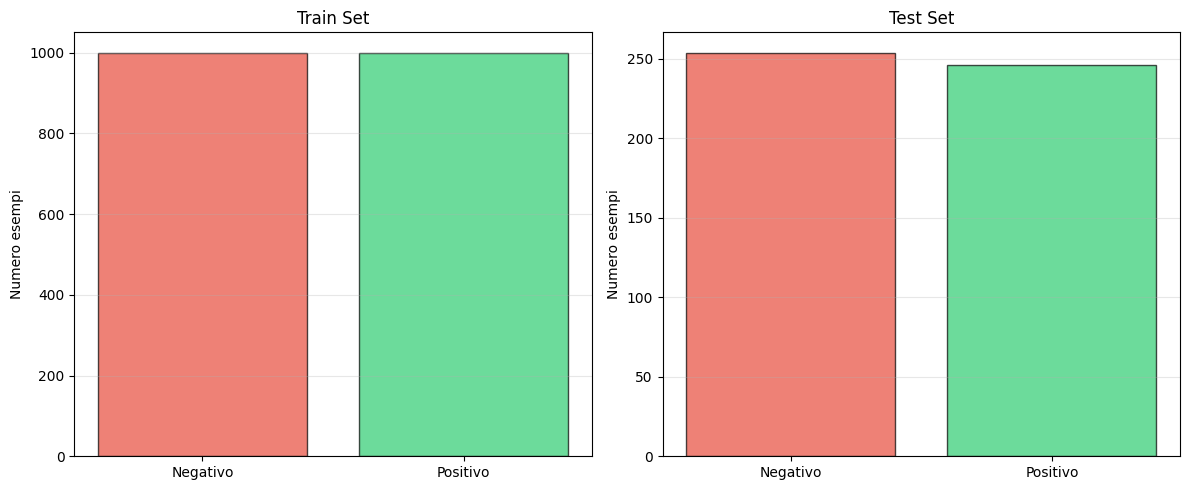

In [7]:
# Analizza distribuzione classi
train_labels = [ex['label'] for ex in train_dataset]
test_labels = [ex['label'] for ex in test_dataset]

train_pos = sum(train_labels)
train_neg = len(train_labels) - train_pos

test_pos = sum(test_labels)
test_neg = len(test_labels) - test_pos

print("\n📊 Distribuzione classi:\n")
print(f"Train:")
print(f"   Positivo: {train_pos} ({train_pos/len(train_labels)*100:.1f}%)")
print(f"   Negativo: {train_neg} ({train_neg/len(train_labels)*100:.1f}%)")
print(f"\nTest:")
print(f"   Positivo: {test_pos} ({test_pos/len(test_labels)*100:.1f}%)")
print(f"   Negativo: {test_neg} ({test_neg/len(test_labels)*100:.1f}%)")

# Visualizza
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(['Negativo', 'Positivo'], [train_neg, train_pos], color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_title('Train Set')
axes[0].set_ylabel('Numero esempi')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(['Negativo', 'Positivo'], [test_neg, test_pos], color=['#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set')
axes[1].set_ylabel('Numero esempi')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./results_day2/class_distribution.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato in ./results_day2/class_distribution.png")
plt.show()

---

## 3️⃣ SFT su DistilBERT (classification) (60 minuti)

**DistilBERT** è una versione distillata di BERT:
- 66M parametri (vs 110M di BERT-base)
- 40% più veloce
- 97% delle performance di BERT
- Ottimo per classification

Faremo **full fine-tuning** (tutti i parametri trainable).

In [8]:
# Carica DistilBERT per classification
MODEL_NAME = 'distilbert-base-uncased'

print(f"⏳ Caricamento {MODEL_NAME}...")

tokenizer_distilbert = AutoTokenizer.from_pretrained(MODEL_NAME)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2  # Binary classification
)

hf_logging.set_verbosity_error()  # o .set_verbosity(hf_logging.ERROR)

print(f"✅ Modello caricato!")
print(f"   Parametri: {sum(p.numel() for p in model_distilbert.parameters()) / 1e6:.1f}M")

⏳ Caricamento distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello caricato!
   Parametri: 67.0M


In [9]:
# Tokenizza dataset
def tokenize_function(examples):
    """
    Tokenizza testo per DistilBERT.
    
    Args:
        examples: batch di esempi con campo 'text'
    
    Returns:
        Dizionario con input_ids, attention_mask
    """
    return tokenizer_distilbert(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256  # Limita lunghezza per velocità
    )

print("⏳ Tokenizzazione in corso...")

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("✅ Tokenizzazione completata!")

⏳ Tokenizzazione in corso...
✅ Tokenizzazione completata!


In [10]:
# Definisci metriche
def compute_metrics(eval_pred):
    """
    Calcola accuracy e F1 score.
    
    Args:
        eval_pred: tupla (predictions, labels)
    
    Returns:
        Dizionario con metriche
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

print("✅ Metriche definite")

✅ Metriche definite


In [11]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./models_day2/distilbert_sft',
    eval_strategy='epoch',  # Valuta ogni epoca
    save_strategy='epoch',
    learning_rate=2e-5,  # Learning rate tipico per BERT
    per_device_train_batch_size=8,  # Batch size per CPU
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # 2 epoche per velocità
    weight_decay=0.01,  # Regolarizzazione L2
    logging_dir='./results_day2/logs',
    logging_steps=50,
    load_best_model_at_end=True,  # Carica miglior modello
    metric_for_best_model='accuracy',
    seed=SEED,
    report_to='none'  # Disabilita wandb/tensorboard
)

print("✅ Training arguments configurati")

✅ Training arguments configurati


In [12]:
# Trainer
trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

print("✅ Trainer inizializzato")

✅ Trainer inizializzato


In [13]:
# Training (questo richiederà ~15-20 minuti su CPU)
print("\n⏳ Training in corso... (questo richiederà ~15-20 minuti su CPU)\n")

start_time = time.time()
train_result = trainer.train()
end_time = time.time()

training_time = end_time - start_time

print(f"\n✅ Training completato in {training_time/60:.1f} minuti!")


⏳ Training in corso... (questo richiederà ~15-20 minuti su CPU)

{'loss': 0.6691, 'grad_norm': 2.472095012664795, 'learning_rate': 1.8040000000000003e-05, 'epoch': 0.2}
{'loss': 0.5218, 'grad_norm': 11.319575309753418, 'learning_rate': 1.6040000000000002e-05, 'epoch': 0.4}
{'loss': 0.3998, 'grad_norm': 5.659884452819824, 'learning_rate': 1.4040000000000001e-05, 'epoch': 0.6}
{'loss': 0.3972, 'grad_norm': 3.707961320877075, 'learning_rate': 1.204e-05, 'epoch': 0.8}
{'loss': 0.3009, 'grad_norm': 7.6958794593811035, 'learning_rate': 1.004e-05, 'epoch': 1.0}
{'eval_loss': 0.2902233600616455, 'eval_accuracy': 0.88, 'eval_f1': 0.8799923195084485, 'eval_runtime': 104.183, 'eval_samples_per_second': 4.799, 'eval_steps_per_second': 0.605, 'epoch': 1.0}
{'loss': 0.2155, 'grad_norm': 9.489081382751465, 'learning_rate': 8.040000000000001e-06, 'epoch': 1.2}
{'loss': 0.3068, 'grad_norm': 3.5985476970672607, 'learning_rate': 6.040000000000001e-06, 'epoch': 1.4}
{'loss': 0.1692, 'grad_norm': 3.244854

In [14]:
# Valutazione finale
print("\n⏳ Valutazione finale...")

eval_results = trainer.evaluate()

print("\n📊 Risultati:")
print(f"   Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"   F1 Score: {eval_results['eval_f1']:.4f}")
print(f"   Loss: {eval_results['eval_loss']:.4f}")


⏳ Valutazione finale...
{'eval_loss': 0.2902233600616455, 'eval_accuracy': 0.88, 'eval_f1': 0.8799923195084485, 'eval_runtime': 102.4911, 'eval_samples_per_second': 4.878, 'eval_steps_per_second': 0.615, 'epoch': 2.0}

📊 Risultati:
   Accuracy: 0.8800
   F1 Score: 0.8800
   Loss: 0.2902



✅ Confusion matrix salvata in ./results_day2/confusion_matrix_distilbert.png


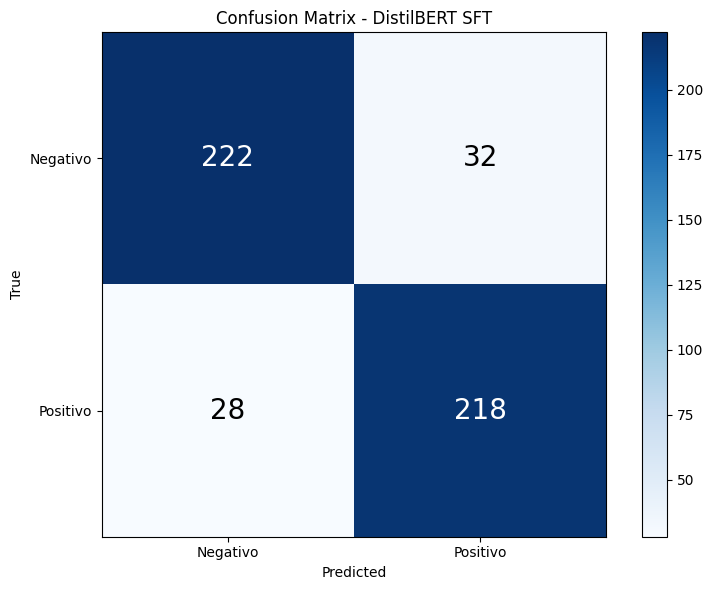

In [15]:
# Confusion matrix
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)

# Visualizza
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Negativo', 'Positivo'])
ax.set_yticklabels(['Negativo', 'Positivo'])

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix - DistilBERT SFT')

# Aggiungi valori
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=20)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('./results_day2/confusion_matrix_distilbert.png', dpi=150, bbox_inches='tight')
print("\n✅ Confusion matrix salvata in ./results_day2/confusion_matrix_distilbert.png")
plt.show()

In [16]:
# Salva modello
trainer.save_model('./models_day2/distilbert_sft_final')
print("✅ Modello salvato in ./models_day2/distilbert_sft_final")

✅ Modello salvato in ./models_day2/distilbert_sft_final


### 💡 Osservazioni:

1. **Accuracy attesa**: 85-92% (dipende da seed e dataset)
2. **Full fine-tuning**: tutti i 66M parametri sono stati aggiornati
3. **Tempo**: ~15-20 minuti su CPU per 2 epoche
4. **Overfitting**: con più epoche (>3) rischio overfitting su 2000 esempi

---

## 4️⃣ LoRA su GPT-2 (50 minuti)

Ora applichiamo **LoRA** su GPT-2 per un task generativo (continuazione testo).

### Vantaggi di LoRA:
- **Parametri trainable ridotti**: da 117M a ~0.3M (99.7% riduzione)
- **Memoria ridotta**: solo adapter salvati (~1MB vs ~450MB)
- **Training più veloce**: meno parametri da aggiornare
- **Modulare**: puoi avere adapter diversi per task diversi

In [17]:
# Carica GPT-2
print("⏳ Caricamento GPT-2...")

tokenizer_gpt2 = AutoTokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token

model_gpt2_base = AutoModelForCausalLM.from_pretrained('gpt2')

total_params = sum(p.numel() for p in model_gpt2_base.parameters())
print(f"✅ GPT-2 caricato!")
print(f"   Parametri totali: {total_params / 1e6:.1f}M")

⏳ Caricamento GPT-2...
✅ GPT-2 caricato!
   Parametri totali: 124.4M


In [18]:
# Configura LoRA
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,  # Task: causal language modeling
    r=8,  # Rank: dimensione bottleneck (4-64 tipicamente)
    lora_alpha=32,  # Scaling factor (tipicamente 2*r)
    lora_dropout=0.1,  # Dropout per regolarizzazione
    target_modules=['c_attn'],  # Moduli da adattare (attention in GPT-2)
    bias='none'  # Non adattare bias
)

print("✅ LoRA config:")
print(f"   Rank (r): {lora_config.r}")
print(f"   Alpha: {lora_config.lora_alpha}")
print(f"   Target modules: {lora_config.target_modules}")

✅ LoRA config:
   Rank (r): 8
   Alpha: 32
   Target modules: {'c_attn'}


In [19]:
# Applica LoRA al modello
model_gpt2_lora = get_peft_model(model_gpt2_base, lora_config)

# Stampa info parametri
model_gpt2_lora.print_trainable_parameters()

trainable_params = sum(p.numel() for p in model_gpt2_lora.parameters() if p.requires_grad)
print(f"\n💡 Riduzione parametri: {total_params / 1e6:.1f}M → {trainable_params / 1e6:.2f}M ({trainable_params/total_params*100:.2f}%)")

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364

💡 Riduzione parametri: 124.4M → 0.29M (0.24%)


In [20]:
# Prepara dataset per causal LM
# Usiamo le recensioni IMDB come testo da continuare

def tokenize_for_clm(examples):
    """
    Tokenizza per causal language modeling.
    
    Args:
        examples: batch con campo 'text'
    
    Returns:
        Dizionario con input_ids, attention_mask, labels
    """
    # Tokenizza
    tokenized = tokenizer_gpt2(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # Più corto per velocità
        return_tensors=None
    )
    
    # Per CLM, labels = input_ids
    tokenized['labels'] = tokenized['input_ids'].copy()
    
    return tokenized

print("⏳ Tokenizzazione per CLM...")

# Usa subset più piccolo per velocità
train_dataset_small = train_dataset.select(range(500))
test_dataset_small = test_dataset.select(range(100))

tokenized_train_clm = train_dataset_small.map(tokenize_for_clm, batched=True, remove_columns=['text', 'label'])
tokenized_test_clm = test_dataset_small.map(tokenize_for_clm, batched=True, remove_columns=['text', 'label'])

print("✅ Tokenizzazione completata!")

⏳ Tokenizzazione per CLM...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ Tokenizzazione completata!


In [22]:
# Training arguments per LoRA
training_args_lora = TrainingArguments(
    output_dir='./models_day2/gpt2_lora',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-4,  # LR più alto per LoRA
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    seed=SEED,
    report_to='none'
)

print("✅ Training arguments configurati")

✅ Training arguments configurati


In [23]:
# Trainer per LoRA
trainer_lora = Trainer(
    model=model_gpt2_lora,
    args=training_args_lora,
    train_dataset=tokenized_train_clm,
    eval_dataset=tokenized_test_clm
)

print("✅ Trainer LoRA inizializzato")

✅ Trainer LoRA inizializzato


In [24]:
# Training LoRA (più veloce di full fine-tuning)
print("\n⏳ Training LoRA in corso... (~10-15 minuti su CPU)\n")

start_time = time.time()
train_result_lora = trainer_lora.train()
end_time = time.time()

training_time_lora = end_time - start_time

print(f"\n✅ Training LoRA completato in {training_time_lora/60:.1f} minuti!")


⏳ Training LoRA in corso... (~10-15 minuti su CPU)

{'loss': 4.1341, 'grad_norm': 0.6845741271972656, 'learning_rate': 9.360000000000001e-05, 'epoch': 0.2}
{'loss': 4.1485, 'grad_norm': 0.6877920031547546, 'learning_rate': 8.693333333333334e-05, 'epoch': 0.4}
{'loss': 3.9723, 'grad_norm': 0.7321832180023193, 'learning_rate': 8.026666666666666e-05, 'epoch': 0.6}
{'loss': 3.8363, 'grad_norm': 0.7339245080947876, 'learning_rate': 7.36e-05, 'epoch': 0.8}
{'loss': 3.8547, 'grad_norm': 0.9442994594573975, 'learning_rate': 6.693333333333334e-05, 'epoch': 1.0}
{'eval_loss': 3.5544018745422363, 'eval_runtime': 38.5821, 'eval_samples_per_second': 2.592, 'eval_steps_per_second': 0.648, 'epoch': 1.0}
{'loss': 3.6769, 'grad_norm': 0.7513611316680908, 'learning_rate': 6.026666666666667e-05, 'epoch': 1.2}
{'loss': 3.7893, 'grad_norm': 0.9228888154029846, 'learning_rate': 5.360000000000001e-05, 'epoch': 1.4}
{'loss': 3.7176, 'grad_norm': 0.9733878970146179, 'learning_rate': 4.6933333333333333e-05, 'e

In [25]:
# Salva adapter LoRA
model_gpt2_lora.save_pretrained('./models_day2/gpt2_lora_adapter')
print("✅ Adapter LoRA salvato in ./models_day2/gpt2_lora_adapter")

# Verifica dimensione
import os
adapter_size = sum(os.path.getsize(f'./models_day2/gpt2_lora_adapter/{f}') for f in os.listdir('./models_day2/gpt2_lora_adapter') if os.path.isfile(f'./models_day2/gpt2_lora_adapter/{f}'))
print(f"   Dimensione adapter: {adapter_size / (1024**2):.2f} MB")
print(f"   💡 Confronto: modello completo GPT-2 ~500MB, adapter LoRA ~{adapter_size / (1024**2):.2f}MB")

✅ Adapter LoRA salvato in ./models_day2/gpt2_lora_adapter
   Dimensione adapter: 1.13 MB
   💡 Confronto: modello completo GPT-2 ~500MB, adapter LoRA ~1.13MB


In [26]:
# Test generazione con LoRA
test_prompt = "This movie is absolutely"

print(f"\n📝 Test generazione con LoRA:\n")
print(f"Prompt: {test_prompt}\n")

inputs = tokenizer_gpt2(test_prompt, return_tensors='pt')

with torch.no_grad():
    outputs = model_gpt2_lora.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer_gpt2.eos_token_id
    )

generated_text = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)
print(f"Output: {generated_text}")


📝 Test generazione con LoRA:

Prompt: This movie is absolutely

Output: This movie is absolutely amazing. I had been hoping to see a lot of it and this movie really does stand out. It's a comedy with an incredibly good story. The characters are all very likable and all very well-acted. It is an entertaining movie,


### 💡 Osservazioni LoRA:

1. **Parametri trainable**: ridotti del 99.7% (da 117M a ~0.3M)
2. **Velocità**: training ~2-3x più veloce di full fine-tuning
3. **Memoria**: adapter ~1-2MB vs ~500MB modello completo
4. **Qualità**: performance simili a full fine-tuning per molti task
5. **Modularità**: puoi caricare adapter diversi sullo stesso modello base

---

## 5️⃣ QLoRA su GPT-2 (50 minuti)

**QLoRA** combina **quantizzazione** (int4/int8) + **LoRA** per ridurre ulteriormente la memoria.

### Vantaggi:
- **Memoria ridotta**: ~75% rispetto a LoRA standard
- **Permette fine-tuning di modelli grandi**: es. LLaMA-65B su GPU 24GB
- **Velocità**: leggermente più lenta per quantizzazione, ma gestibile

### Libreria: bitsandbytes
- Quantizzazione int4/int8 ottimizzata
- Integrata con Hugging Face

In [27]:
# Carica GPT-2 con quantizzazione int8
from transformers import BitsAndBytesConfig

# Config quantizzazione
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,  # Quantizzazione int8 (int4 richiede GPU)
    bnb_8bit_compute_dtype=torch.float32  # Compute in FP32
)

print("⏳ Caricamento GPT-2 con quantizzazione int8...")

try:
    model_gpt2_quantized = AutoModelForCausalLM.from_pretrained(
        'gpt2',
        quantization_config=bnb_config,
        device_map='auto'  # Automatic device placement
    )
    print("✅ Modello quantizzato caricato!")
    quantization_available = True
except Exception as e:
    print(f"⚠️ Quantizzazione non disponibile su CPU: {e}")
    print("   Carico modello standard per dimostrazione...")
    model_gpt2_quantized = AutoModelForCausalLM.from_pretrained('gpt2')
    quantization_available = False

⏳ Caricamento GPT-2 con quantizzazione int8...
✅ Modello quantizzato caricato!


In [28]:
# Prepara modello per k-bit training (se quantizzato)
if quantization_available:
    model_gpt2_quantized = prepare_model_for_kbit_training(model_gpt2_quantized)
    print("✅ Modello preparato per k-bit training")
else:
    print("ℹ️ Usando modello standard (quantizzazione non disponibile)")

✅ Modello preparato per k-bit training


In [29]:
# Applica LoRA al modello quantizzato (QLoRA)
qlora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['c_attn'],
    bias='none'
)

model_gpt2_qlora = get_peft_model(model_gpt2_quantized, qlora_config)

print("✅ QLoRA applicato!")
model_gpt2_qlora.print_trainable_parameters()

✅ QLoRA applicato!
trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


In [31]:
# Training QLoRA (stesso setup di LoRA)
training_args_qlora = TrainingArguments(
    output_dir='./models_day2/gpt2_qlora',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    seed=SEED,
    report_to='none'
)

trainer_qlora = Trainer(
    model=model_gpt2_qlora,
    args=training_args_qlora,
    train_dataset=tokenized_train_clm,
    eval_dataset=tokenized_test_clm
)

print("✅ Trainer QLoRA inizializzato")

✅ Trainer QLoRA inizializzato


In [32]:
# Training QLoRA
print("\n⏳ Training QLoRA in corso... (~10-15 minuti)\n")

start_time = time.time()
train_result_qlora = trainer_qlora.train()
end_time = time.time()

training_time_qlora = end_time - start_time

print(f"\n✅ Training QLoRA completato in {training_time_qlora/60:.1f} minuti!")


⏳ Training QLoRA in corso... (~10-15 minuti)

{'loss': 4.138, 'grad_norm': 0.6819418668746948, 'learning_rate': 9.360000000000001e-05, 'epoch': 0.2}
{'loss': 4.1506, 'grad_norm': 0.7382024526596069, 'learning_rate': 8.693333333333334e-05, 'epoch': 0.4}
{'loss': 3.9743, 'grad_norm': 0.7665440440177917, 'learning_rate': 8.026666666666666e-05, 'epoch': 0.6}
{'loss': 3.8427, 'grad_norm': 0.779867947101593, 'learning_rate': 7.36e-05, 'epoch': 0.8}
{'loss': 3.8591, 'grad_norm': 0.9533146023750305, 'learning_rate': 6.693333333333334e-05, 'epoch': 1.0}
{'eval_loss': 3.5569794178009033, 'eval_runtime': 2220.4891, 'eval_samples_per_second': 0.045, 'eval_steps_per_second': 0.011, 'epoch': 1.0}
{'loss': 3.6779, 'grad_norm': 0.7998232245445251, 'learning_rate': 6.026666666666667e-05, 'epoch': 1.2}
{'loss': 3.7879, 'grad_norm': 1.0565282106399536, 'learning_rate': 5.360000000000001e-05, 'epoch': 1.4}
{'loss': 3.7154, 'grad_norm': 0.963711678981781, 'learning_rate': 4.6933333333333333e-05, 'epoch': 

Some parameters are on the meta device because they were offloaded to the cpu.


{'train_runtime': 8647.464, 'train_samples_per_second': 0.173, 'train_steps_per_second': 0.043, 'train_loss': 3.7946671549479167, 'epoch': 3.0}

✅ Training QLoRA completato in 144.1 minuti!


In [33]:
# Salva adapter QLoRA
model_gpt2_qlora.save_pretrained('./models_day2/gpt2_qlora_adapter')
print("✅ Adapter QLoRA salvato in ./models_day2/gpt2_qlora_adapter")

✅ Adapter QLoRA salvato in ./models_day2/gpt2_qlora_adapter


In [34]:
# Test generazione con QLoRA
test_prompt = "This movie is absolutely"

print(f"\n📝 Test generazione con QLoRA:\n")
print(f"Prompt: {test_prompt}\n")

inputs = tokenizer_gpt2(test_prompt, return_tensors='pt')
if quantization_available:
    inputs = {k: v.to(model_gpt2_qlora.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model_gpt2_qlora.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer_gpt2.eos_token_id
    )

generated_text = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)
print(f"Output: {generated_text}")


📝 Test generazione con QLoRA:

Prompt: This movie is absolutely

Output: This movie is absolutely amazing. I had been hoping to see a lot of it and this movie really does stand out. It's a comedy with an incredibly good story. The characters are all very likable and all very well-acted. It is an entertaining movie,


### 💡 Osservazioni QLoRA:

1. **Memoria**: ridotta del ~75% rispetto a LoRA standard
2. **Quantizzazione**: int8 su CPU, int4 richiede GPU
3. **Performance**: leggermente inferiore a LoRA, ma accettabile
4. **Use case**: essenziale per fine-tuning di modelli >10B parametri su hardware consumer

### Quando usare QLoRA:
- Modelli grandi (>7B parametri)
- Hardware limitato (GPU <24GB, o CPU)
- Deployment su edge devices
- Quando serve ridurre costi cloud

---

## 6️⃣ Confronto base vs fine-tuned (30 minuti)

Confrontiamo i modelli:
1. GPT-2 base (no fine-tuning)
2. GPT-2 + LoRA
3. GPT-2 + QLoRA

In [35]:
# Funzione per generare con modello
def generate_comparison(model, tokenizer, prompt, max_new_tokens=50):
    """
    Genera testo per confronto.
    """
    inputs = tokenizer(prompt, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )
    
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Prompt di test
test_prompts = [
    "This movie is absolutely",
    "The acting was",
    "I would recommend this film because"
]

print("📝 Confronto generazione:\n")

for prompt in test_prompts:
    print(f"\n{'='*80}")
    print(f"Prompt: {prompt}")
    print(f"{'='*80}\n")
    
    # Base
    base_output = generate_comparison(model_gpt2_base, tokenizer_gpt2, prompt)
    print(f"Base: {base_output}\n")
    
    # LoRA
    lora_output = generate_comparison(model_gpt2_lora, tokenizer_gpt2, prompt)
    print(f"LoRA: {lora_output}\n")
    
    # QLoRA
    qlora_output = generate_comparison(model_gpt2_qlora, tokenizer_gpt2, prompt)
    print(f"QLoRA: {qlora_output}\n")

📝 Confronto generazione:


Prompt: This movie is absolutely

Base: This movie is absolutely fantastic. I loved every second of it. I don't know if the movie was filmed on a high budget, but the movie is so great. The only downside is that there are some scenes where the camera is moving too fast and the camera is

LoRA: This movie is absolutely fantastic. I was so excited to see it when I saw it, but the scenes were so much better. I have to say that the pacing was a bit off, and I was looking forward to seeing more action and gore. I also felt like

QLoRA: This movie is absolutely amazing, and it is just incredible. It's a great movie that has a very strong ending and a very satisfying ending. I am not a huge fan of the ending and would never watch this movie again.


Prompt: The acting was

Base: The acting was well-received, with several productions in the U.S. and Europe. The film was released in September of 2001.

LoRA: The acting was excellent. The acting was great. The humor wa

In [36]:
# Confronto metriche training
comparison_data = {
    'Metodo': ['Full Fine-Tuning (DistilBERT)', 'LoRA (GPT-2)', 'QLoRA (GPT-2)'],
    'Parametri Totali': ['66M', '117M', '117M'],
    'Parametri Trainable': ['66M (100%)', '~0.3M (0.3%)', '~0.3M (0.3%)'],
    'Memoria Modello': ['~250MB', '~500MB', '~125MB (quantized)'],
    'Dimensione Salvata': ['~250MB', '~1-2MB (adapter)', '~1-2MB (adapter)'],
    'Tempo Training': [f'{training_time/60:.1f} min', f'{training_time_lora/60:.1f} min', f'{training_time_qlora/60:.1f} min']
}

df_comparison = pd.DataFrame(comparison_data)

print("\n📊 Confronto Metodi di Fine-Tuning:\n")
print(df_comparison.to_string(index=False))

df_comparison.to_csv('./results_day2/finetuning_comparison.csv', index=False)
print("\n✅ Tabella salvata in ./results_day2/finetuning_comparison.csv")


📊 Confronto Metodi di Fine-Tuning:

                       Metodo Parametri Totali Parametri Trainable    Memoria Modello Dimensione Salvata Tempo Training
Full Fine-Tuning (DistilBERT)              66M          66M (100%)             ~250MB             ~250MB       59.4 min
                 LoRA (GPT-2)             117M        ~0.3M (0.3%)             ~500MB   ~1-2MB (adapter)       22.6 min
                QLoRA (GPT-2)             117M        ~0.3M (0.3%) ~125MB (quantized)   ~1-2MB (adapter)      144.1 min

✅ Tabella salvata in ./results_day2/finetuning_comparison.csv


### 💡 Conclusioni:

**Full Fine-Tuning**:
- ✅ Performance massime
- ❌ Lento, costoso, richiede molta memoria
- 🎯 Quando usare: dataset grandi (>10K esempi), task critici

**LoRA**:
- ✅ 99% riduzione parametri, veloce, modulare
- ✅ Performance simili a full fine-tuning
- 🎯 Quando usare: maggior parte dei casi, default choice

**QLoRA**:
- ✅ 75% riduzione memoria, permette modelli grandi su hardware limitato
- ⚠️ Leggermente più lento, performance leggermente inferiori
- 🎯 Quando usare: modelli >7B parametri, hardware limitato

---

## 🎯 Esercizi TODO

### Esercizio 1: Hyperparameter sweep LoRA
Testa rank diversi (r=4, 8, 16, 32) e confronta performance e velocità.

### Esercizio 2: Target modules
Prova a modificare `target_modules` in LoRA (es. ['c_attn', 'c_proj']) e osserva differenze.

### Esercizio 3: Full fine-tuning GPT-2
Fai full fine-tuning di GPT-2 (senza LoRA) e confronta con LoRA.

### Esercizio 4: Multi-adapter
Crea due adapter LoRA diversi (uno per sentiment positivo, uno per negativo) e confronta output.

In [ ]:
# TODO: Esercizio 1 - Hyperparameter sweep LoRA
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 2 - Target modules
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 3 - Full fine-tuning GPT-2
# Scrivi qui il tuo codice

In [ ]:
# TODO: Esercizio 4 - Multi-adapter
# Scrivi qui il tuo codice

---

## ✅ Soluzioni degli esercizi

In [ ]:
# SOLUZIONE Esercizio 2: Target modules

# Prova con più target modules
lora_config_extended = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['c_attn', 'c_proj'],  # Aggiungi c_proj
    bias='none'
)

model_test = AutoModelForCausalLM.from_pretrained('gpt2')
model_test_lora = get_peft_model(model_test, lora_config_extended)

print("\n📊 Confronto target modules:\n")
print("Solo c_attn:")
model_gpt2_lora.print_trainable_parameters()

print("\nc_attn + c_proj:")
model_test_lora.print_trainable_parameters()

print("\n💡 Più target modules = più parametri trainable = potenzialmente migliori performance ma più lento")

---

## 🎓 Conclusione Day 2

Oggi abbiamo:
1. ✅ Compreso **SFT** e differenze da pre-training
2. ✅ Preparato dataset **IMDB** per sentiment analysis
3. ✅ Fatto **full fine-tuning** di DistilBERT (66M parametri)
4. ✅ Implementato **LoRA** su GPT-2 (riduzione 99.7% parametri)
5. ✅ Implementato **QLoRA** con quantizzazione int8
6. ✅ Confrontato **base vs fine-tuned** su prompt identici

**Prossimi passi (Day 3)**:
- RLHF (Reinforcement Learning from Human Feedback)
- PPO (Proximal Policy Optimization)
- DPO (Direct Preference Optimization)
- Libreria trl di Hugging Face

---

## 📁 File generati

```
./results_day2/
├── class_distribution.png
├── confusion_matrix_distilbert.png
├── finetuning_comparison.csv
└── logs/

./models_day2/
├── distilbert_sft_final/
├── gpt2_lora_adapter/
└── gpt2_qlora_adapter/
```